In [3]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import modin.pandas as pd
import matplotlib.pyplot as plt

In [4]:
output_dir = 'model_output/dense'

### Set hyperparameters

In [5]:
# training
EPOCHS = 4
BATCH_SIZE = 128

# vector-space embedding
N_DIM = 64
N_UNIQUE_WORDS = 5000
N_WORDS_TO_SKIP = 50 # 50'den fazla tekrar eden kelimeler, stop words olarak dusunulebilir
MAX_REVIEW_LENGTH = 100
PAD_TYPE = TRUNC_TYPE = 'pre'

# neural network architecture
N_DENSE = 64
DROPOUT = 0.5

In [23]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words = N_UNIQUE_WORDS,
                                                       skip_top=N_WORDS_TO_SKIP)

In [24]:
print(X_train[0])
# 0 reserved for padding
# 1 would be starting char
# 2 is UNKOWN, which is out of top 5000 words (N_UNIQUE_WORDS) are considered as unkown here
# 3 is the most common word etc.

[2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]


In [25]:
for index, review in enumerate(X_train[0:6]):
    print(f'{index+1}. movie review lengfth is : {len(review)}')

1. movie review lengfth is : 218
2. movie review lengfth is : 189
3. movie review lengfth is : 141
4. movie review lengfth is : 550
5. movie review lengfth is : 147
6. movie review lengfth is : 43


In [26]:
print(y_train[0:6])
# 0 --> negative
# 1 --> positive

[1 0 0 1 0 0]


In [27]:
print(len(X_train), len(y_train))
print(len(X_valid), len(y_valid))

25000 25000
25000 25000


### Restoring words from index

In [29]:
word_index = tensorflow.keras.datasets.imdb.get_word_index()
word_index = {k: (v+3) for k, v in word_index.items()}
word_index['PAD'] = 0
word_index['START'] = 1
word_index['UNK'] = 2

In [34]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [35]:
index_word = {v:k for k, v in word_index.items()}

In [36]:
index_word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [37]:
print(X_train[0])

[2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]


In [38]:
' '.join(index_word[id] for id in X_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

### Preprocess Data

In [40]:
X_train = pad_sequences(X_train, maxlen=MAX_REVIEW_LENGTH,
                      padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

X_valid = pad_sequences(X_valid, maxlen=MAX_REVIEW_LENGTH,
                      padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

In [41]:
X_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [42]:
for index, review in enumerate(X_train[0:6]):
    print(f'{index+1}. movie review lengfth is : {len(review)}')

1. movie review lengfth is : 100
2. movie review lengfth is : 100
3. movie review lengfth is : 100
4. movie review lengfth is : 100
5. movie review lengfth is : 100
6. movie review lengfth is : 100


### Design NN Architecture

In [84]:
model = Sequential()

# first hidden layer --> Embedding Layer
model.add(Embedding(N_UNIQUE_WORDS, N_DIM, input_length=MAX_REVIEW_LENGTH))

# Flatten layers converts into 1D array, cuz Dense Layer accpets only 1D array
model.add(Flatten())

# second hidden layer --> Dense Layer
model.add(Dense(N_DENSE, activation='relu'))
model.add(Dropout(DROPOUT))

# third hidden layer --> Dense Layer
model.add(Dense(N_DENSE/2, activation='relu'))
model.add(Dropout(DROPOUT))


# output layer
model.add(Dense(1, activation='sigmoid'))

In [85]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [86]:
# embedding layer dimension and parameters

N_DIM, N_UNIQUE_WORDS, N_DIM*N_UNIQUE_WORDS
# we have 64 dimentional 5000 words so in total 320K trainable parameters

(64, 5000, 320000)

In [87]:
# flatten layer
MAX_REVIEW_LENGTH, N_DIM, N_DIM*MAX_REVIEW_LENGTH
# we have fix size (100) movie reviews and each has 64 dimentions

(100, 64, 6400)

In [88]:
# dense layer
N_DENSE, N_DIM*MAX_REVIEW_LENGTH*N_DENSE+N_DENSE # weight + biases

(64, 409664)

In [89]:
# output layer
N_DENSE + 1 # 1 is coming from bias for the output layer

65

### Configure Model

In [90]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [91]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [92]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train

In [93]:
model.fit(X_train, y_train,
         batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
         validation_data=(X_valid, y_valid),
         callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 113us/sample - loss: 0.6091 - accuracy: 0.6353 - val_loss: 0.3685 - val_accuracy: 0.8364
Epoch 2/4
25000/25000 [==============================] - 2s 87us/sample - loss: 0.3234 - accuracy: 0.8743 - val_loss: 0.3492 - val_accuracy: 0.8448
Epoch 3/4
25000/25000 [==============================] - 2s 88us/sample - loss: 0.1540 - accuracy: 0.9508 - val_loss: 0.4766 - val_accuracy: 0.8280
Epoch 4/4
25000/25000 [==============================] - 2s 89us/sample - loss: 0.0479 - accuracy: 0.9872 - val_loss: 0.7147 - val_accuracy: 0.8146


In [63]:
# Best epoch is the second epoch actually if we check the accuracy and loss
# Evaluation icin bunu kullanacagiz

### Evaluate

In [64]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [65]:
y_pred = model.predict_proba(X_valid)

In [66]:
len(y_pred)

25000

In [67]:
y_pred[0]

array([0.34876084], dtype=float32)

In [68]:
y_valid[0]

0

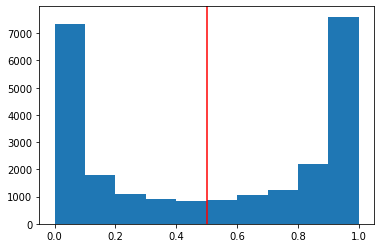

In [70]:
plt.hist(y_pred)
_ = plt.axvline(x=0.5, color='red')

In [71]:
pct_auc = roc_auc_score(y_valid, y_pred) * 100.0

In [72]:
"{:0.2f}".format(pct_auc) # 1 is perfect

'92.73'

In [74]:
float_y_pred = []
for y in y_pred:
    float_y_pred.append(y[0])

In [77]:
y_df = pd.DataFrame(list(zip(float_y_pred, y_valid)), columns=['y_pred', 'y_valid']) 

In [78]:
y_df.head()

,y_pred,y_valid
0,0.348761,0
1,0.976560,1
2,0.862346,1
3,0.612374,0
4,0.992911,1


In [79]:
y_df[(y_df.y_valid==0) & (y_df.y_pred>0.9)]
# bunlar gercek label 0 olup model tarafindan cok yuksek confidence levell ile yanlis predict edilenler

,y_pred,y_valid
8,0.913612,0
75,0.922929,0
152,0.908638,0
386,0.964587,0
495,0.955000,0
...,...,...
24136,0.956184,0
24231,0.934158,0
24692,0.964384,0
24696,0.956769,0


In [81]:
' '.join(index_word[id] for id in X_valid[24136])

"UNK UNK perfect UNK UNK terrible UNK terrible you'll love UNK get UNK friends lots UNK beer UNK you'll UNK UNK time UNK your life UNK UNK UNK party waiting UNK happen enjoy UNK UNK worth UNK rental UNK UNK UNK UNK type cop UNK UNK comic relief UNK UNK bad guy will UNK UNK UNK UNK floor laughing he's also UNK another UNK UNK UNK vs UNK UNK he's UNK UNK good there UNK don't know what UNK budget UNK UNK they'll get UNK back because UNK UNK UNK UNK UNK UNK UNK best UNK comedy UNK UNK year"

In [83]:
y_df[(y_df.y_valid==1) & (y_df.y_pred<0.2)]
# Bunlar da gercekte positive olup model tarafindan kuvvetli bir sekilde negative olarak tahmin edilenler

,y_pred,y_valid
22,0.107100,1
45,0.084152,1
100,0.189937,1
101,0.051162,1
159,0.192392,1
...,...,...
24783,0.188498,1
24789,0.071027,1
24863,0.062551,1
24949,0.151446,1
